# Week 8 - Clustering (Unsupervised Learning)

## Learning Objectives
+ Hierarchical Clustering
+ K-Means clustering
    + Difference with hierarchical clustering
    + Reducing the dimensions of high dimensional data
        + PCA
        + t-SNE
    + Methods of finding number of clusters:
        + Using silhoutte analysis
        + Using elbow method

The contents of this tutorial are based on the chapter 10 of "An Introduction to Statistical Learning" by James G. et. al., python [notebook](https://nbviewer.jupyter.org/github/JWarmenhoven/ISL-python/blob/master/Notebooks/Chapter%2010.ipynb#Lab-3:-NCI60-Data-Example) on same chapter, sklearn [tutorial](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) on k-means, sklearn [tutorial](https://scikit-learn.org/stable/modules/clustering.html) on clustering, sklearn [tutorial](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html) on agglomerative clustering, and introduction to dimensionality reduction [tutorial](https://www.datacamp.com/community/tutorials/introduction-t-sne).

## Loading the NCI-60 dataset

NCI60 is cancer cell line microarray data, which consists of 6,830 gene expression measurements on 64 cancer cell lines. So, our data is 64x6830, implying that the n<\<p. In case of such high-dimensional data, methods such as regression do not remain applicable. Dimensionality reduction is also useful for such data, before applying different ML models. 

Gene data is usually always a high-dimensionality data, and is useful in precision medicine - i.e. to recommend personalized treatment to patients. A common approach for such personalized treatment is categorizing the patients into various sub-types. For such sub-typing, clustering is usually performed and can be used to identify patients who are similar - to analyze their treatments and decide the further course of treatment for the patient under consideration.  

In our data, though we have cancer type label for each cell-line, in real-life data, we typically do not have this for all the patients, making the clustering quite important. Usually clustering methods are then analyzed on various datasets, and validation from the domain - such as the cancer types in our case are used to identifying a more superior technique to be used. 

Our data has gene expression measurement which is usually achieved by quantifying levels of the gene product, which is often a protein.

In [10]:
import pandas as pd
import numpy as np

In [11]:
rng = np.random.RandomState(10)

In [14]:
# df = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/nci.data.csv')
df = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/nci.data.csv', skiprows=1, header=None).T
# from pandas 0.19.2 onwards, we can directly pass the url to read_csv

In [17]:
df.head()

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,...,g6821,g6822,g6823,g6824,g6825,g6826,g6827,g6828,g6829,g6830
1,0.3,1.18,0.55,1.14,-0.265,-0.07,0.35,-0.315,-0.45,-0.65498,...,-0.99002,0.0,0.03,-0.175,0.629981,-0.03,0.0,0.28,-0.34,-1.93
2,0.679961,1.289961,0.169961,0.379961,0.464961,0.579961,0.699961,0.724961,-0.040039,-0.285019,...,-0.270058,-0.300039,-0.250039,-0.535039,0.109941,-0.860039,-1.250049,-0.770039,-0.390039,-2.000039
3,0.94,-0.04,-0.17,-0.04,-0.605,0.0,0.09,0.645,0.43,0.475019,...,0.319981,0.12,-0.74,-0.595,-0.27002,-0.15,0.0,-0.12,-0.41,0.0
4,0.28,-0.31,0.68,-0.81,0.625,-0.0,0.17,0.245,0.02,0.095019,...,-1.24002,-0.11,-0.16,0.095,-0.350019,-0.3,-1.15001,1.09,-0.26,-1.1
5,0.485,-0.465,0.395,0.905,0.2,-0.005,0.085,0.11,0.235,1.490019,...,0.55498,-0.775,-0.515,-0.32,0.63498,0.605,0.0,0.745,0.425,0.145


In [16]:

df.columns = df.iloc[0]                            # Set new column names
df.drop(0,inplace=True)                            # Drop duplicated row

In [18]:
labs = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/nci.label.txt', names=['type'], dtype="category")

In [22]:
labs.type = labs.type.str.strip()

In [23]:
labs.head()

,type
0,CNS
1,CNS
2,CNS
3,RENAL
4,BREAST


In [24]:
labs.value_counts()

type       
NSCLC          9
RENAL          9
MELANOMA       8
BREAST         7
COLON          7
LEUKEMIA       6
OVARIAN        6
CNS            5
PROSTATE       2
K562A-repro    1
K562B-repro    1
MCF7A-repro    1
MCF7D-repro    1
UNKNOWN        1
dtype: int64

In [25]:
labs.nunique()

type    14
dtype: int64

# Hierarchical Clustering

Let us first try to find out whether or not the observations cluster into distinct types of cancer. 

Here we have an option to standardize the variables to have mean zero and standard deviation one. However, this step is optional and should be performed only if we want each gene to be on the same scale. We could reasonably argue that it is better not to scale genes. However, it is a choice to make as a data analyst, and also evaluate experimentally.

## Agglomerative Clustering
This is a bottom-up clustering, and is built starting from the leaves and combining clusters up to the trunk. Each dendogram will represent each of our 64 samples. As we move up the tree, some leaves begin to fuse into branches. These correspond to
observations that are similar to each other. As we move higher up the tree, branches themselves fuse, either with leaves or other branches. The earlier (lower in the tree) fusions occur, the more similar the groups of observations are to each other. Thus, the height of the fusion depicts how different the observations are.

![Agglomerative Clustering](https://dashee87.github.io/images/hierarch.gif)

The [```AgglomerativeClustering```](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) class in sklearn implements four different types of linkages. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.
+ ‘ward’ minimizes the variance of the clusters being merged.
+ ‘average’ uses the average of the distances of each observation of the two sets.
+ ‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.
+ ‘single’ uses the minimum of the distances between all observations of the two sets.

The default is ward. Usually complete linkage is used for Gene data.

In [26]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
%matplotlib inline

Let us write a function to plot dendogram. We use the [```cluster.hierarchy.dendogram```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram). The [```cluster.hierarchy```]() is available in scipy which has functions that cut hierarchical clusterings into flat clusterings or find the roots of the forest formed by a cut by providing the flat cluster ids of each observation. We will see usage of both these API - the sklearn and the scipy.

In [27]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df)
model.labels_

array([57, 48, 45, 61, 35, 63, 55, 33, 32, 59, 43, 56, 44, 49, 50, 46, 36,
       24, 41, 37, 60, 40, 34, 42, 38, 39, 19, 31, 47, 16, 51, 20, 18, 52,
       29, 27, 58, 17, 53,  9, 28, 54, 15, 62, 23,  8, 11, 13, 30,  7, 22,
       21,  3, 26, 25, 10, 14, 12,  4,  5,  6,  2,  1,  0])

In [28]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


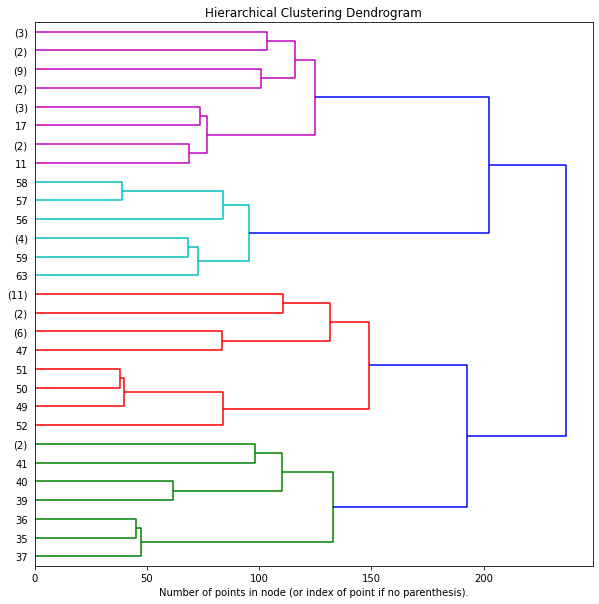

In [30]:
plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram, where p is the number of levels to truncate at
# how do we use plot_dendrogram?
plot_dendrogram(model, truncate_mode = "level",p=4, labels =df.index, orientation = "right")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

The ```model.children_``` attribute we use shows the children of each non-leaf node. Values less than ```n_samples``` correspond to leaves of the tree which are the original samples. A node ```i``` greater than or equal to ```n_samples``` is a non-leaf node and has children ```children_[i - n_samples]```. Alternatively at the i-th iteration, ```children[i][0]``` and ```children[i][1]``` are merged to form node ```n_samples + i```.

In [31]:
model.children_[:5,:] 

array([[49, 50],
       [56, 57],
       [48, 64],
       [20, 21],
       [34, 35]])

Now we can use the scipy API and also scale the gene data and see the clusters. 

In [32]:
from scipy.cluster import hierarchy
from sklearn.preprocessing import scale

In [33]:
X = pd.DataFrame(scale(df), index=labs.type, columns=df.columns)

In [34]:
X

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,...,g6821,g6822,g6823,g6824,g6825,g6826,g6827,g6828,g6829,g6830
type,,,,,,,,,,,,,,,,,,,,,
CNS,0.728671,1.607220,1.325688,1.355688,-0.604845,-0.220654,0.898137,-0.868741,-1.058612,-1.059174,...,-1.030663,-0.358518,-0.238245,-0.392487,0.831370,-0.200286,-0.075668,0.520893,-0.836365,-1.384675
CNS,1.596418,1.753544,0.441686,0.654119,0.911898,1.648748,1.849697,2.226625,-0.095860,-0.477977,...,-0.215657,-0.625720,-0.489938,-0.800791,0.013818,-1.105413,-1.117676,-0.823652,-0.925425,-1.431446
CNS,2.190290,-0.016217,-0.349092,0.266465,-1.311310,-0.019322,0.191185,1.988627,1.007979,0.716019,...,0.452274,-0.251651,-0.930304,-0.868790,-0.583517,-0.331142,-0.075668,0.008704,-0.960951,-0.095838
RENAL,0.682995,-0.375502,1.628079,-0.444299,1.244434,-0.019322,0.408709,0.798057,0.045135,0.119051,...,-1.313667,-0.456479,-0.409013,-0.086293,-0.709285,-0.494711,-1.034286,1.558075,-0.693981,-0.830408
BREAST,1.151170,-0.581759,0.965145,1.138767,0.361351,-0.033703,0.177590,0.396239,0.550041,2.310550,...,0.718297,-1.048700,-0.728079,-0.556925,0.839231,0.492157,-0.075668,1.116312,0.525182,0.000992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MELANOMA,-0.024977,-0.601719,0.209168,-0.342761,-0.459396,1.159911,-0.706100,0.381357,-0.964676,1.344405,...,-0.362775,-0.224934,-0.651683,-0.029591,-0.300540,-0.189382,-1.234343,-1.310181,0.284909,0.698834
MELANOMA,-0.573084,0.875343,-0.186266,1.318766,2.117127,0.210772,-0.298243,-1.940254,-0.729836,0.401825,...,-0.543897,-0.180407,-0.004563,-0.233720,0.281136,-0.342046,-0.092347,-0.657141,-0.889759,-0.382988
MELANOMA,0.523130,-0.788015,-0.302571,-0.924296,0.039286,-1.169792,-1.113957,-1.940254,-0.847256,1.454373,...,-0.091092,-0.465385,0.498752,-0.335785,1.067185,0.257708,-0.075668,0.367236,3.381761,2.535260


We can scale data using ```scale(df)``` which centers the mean and component wise scale to unit variance, along any axis. We scale such that the mean of every column is 0 and the standard deviation of every column is 1.

In [35]:
# how do we show that the data has been scaled?
np.mean(scale(df), axis =0), np.std(scale(df), axis = 0)


(array([ 2.77555756e-17, -1.38777878e-17,  0.00000000e+00, ...,
         2.77555756e-17, -6.93889390e-18,  6.93889390e-18]),
 array([1., 1., 1., ..., 1., 1., 1.]))

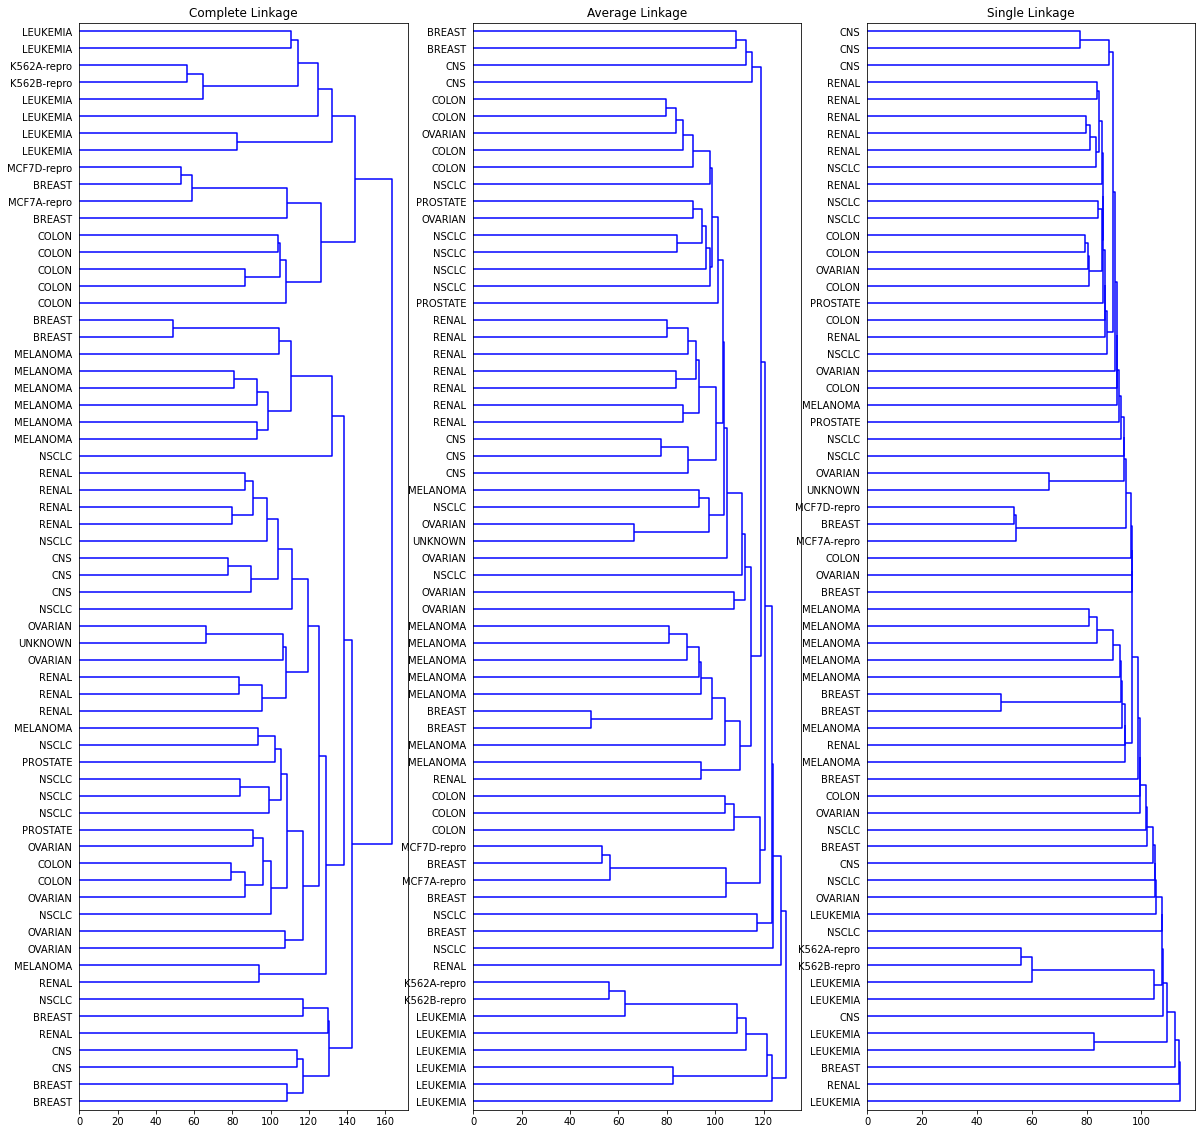

In [36]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,20))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)],
                                ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = dendrogram(linkage, labels=X.index, orientation='right', color_threshold=0, leaf_font_size=10, ax=ax)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage');

We see that the choice of linkage affects the results obtained. Typically, single linkage will tend to yield trailing clusters: very large clusters onto which individual observations attach one-by-one. On the other hand, complete and average linkage tend to yield more balanced, attractive clusters. For this reason, complete and average linkage are generally preferred to single linkage. 

In the complete linkage, we can set the threshold at 140, to get four clusters. Increasing the threshold decreases the number of clusters. For example, increasing the threshold to 150 results in only 2 clusters. This is useful in selecting the number of clusters we want. 

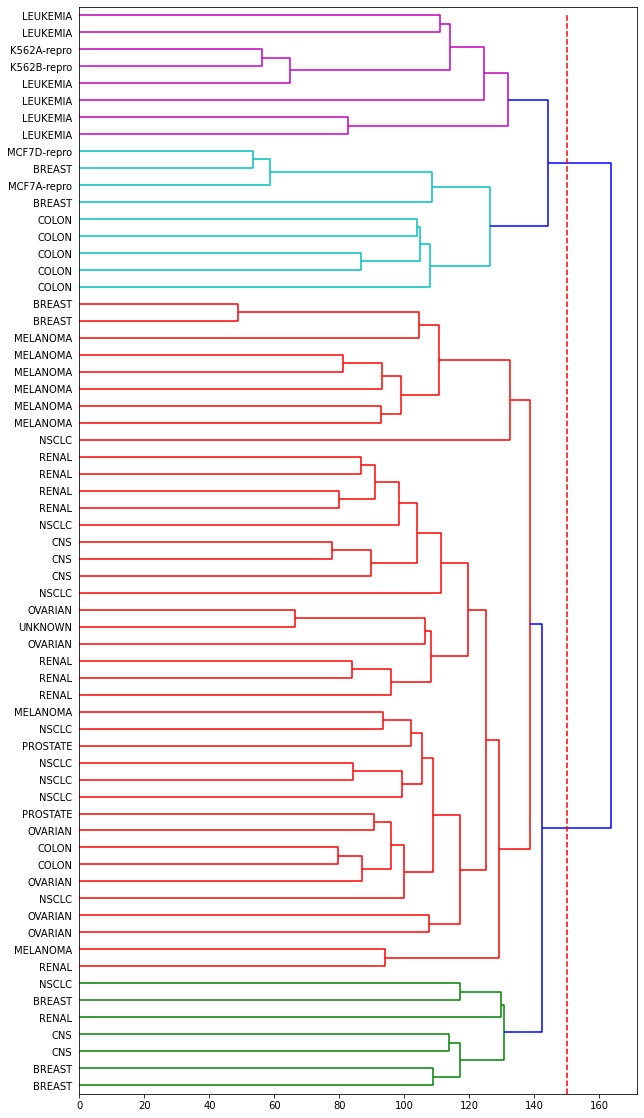

In [39]:
plt.figure(figsize=(10,20))
cut4 = hierarchy.dendrogram(hierarchy.complete(X),
                            labels=X.index, orientation='right', color_threshold=140, leaf_font_size=10)
# this plot is compatible with matplotlib. can we insert a line at the threshold of 140?
plt.vlines(150, 0, plt.gca().yaxis.get_data_interval()[1], color = 'r', linestyle = 'dashed')

Based on this cut, we can see the four clusters in four colors. We see all the leukemia cell lines fall in one cluster,
while the breast cancer cell lines are spread out over three different clusters

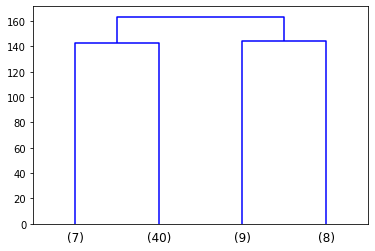

In [40]:
cut4c = hierarchy.dendrogram(hierarchy.complete(X), truncate_mode='lastp', p=4,
                             show_leaf_counts=True)

# K-Means for same number of clusters
We can perform K-Means with same number of clusters and check the clusters that are formed. 

In K Means clustering, since we start with random choice of clusters, the results produced by running the algorithm multiple times might differ. While results are reproducible in Hierarchical clustering.

![KMeans Clustering](https://miro.medium.com/max/600/1*h2WdqGZD6WsNcUdwZDqsFA.gif)

In [41]:
from sklearn.cluster import KMeans

In [42]:
np.random.seed(2)
# we set up KMeans clustering with 4 clusters, let the algorithm run with 50 different centroid seeds. 
km4 = KMeans(n_clusters =4, n_init = 50, random_state = rng)
km4.fit(X)

KMeans(n_clusters=4, n_init=50,
       random_state=RandomState(MT19937) at 0x7F6AABB886B0)

In [43]:
km4.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [44]:
# Observations per KMeans cluster
pd.Series(km4.labels_).value_counts().sort_index()

0     9
1    27
2    20
3     8
dtype: int64

We see that though clustering has been done in same number of clusters - the observations per cluster is different and the clusters themselves must also be different. You can do visualizations along with the cancer types to actually see the difference between the clusters using both algorithms.

# Finding k 
Unlike the hierarchical clustering, the k-means clustering has the problem of specifying the number of clusters (k). How do we find this? We have two popular methods for this approach:
+ Silhoutte Method
+ Elbow Method

## Silhoutte method
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of \[-1, 1\].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

### Performing dimensionality reduction - PCA
Sometimes performing clustering on the first few principal component score vectors can give better results than performing clustering on the full data. In this situation, we might view the principal component step as one of denoising the data. You can of course perform the clustering without the PCA, however, on this specific data, the PCA helps in finding more meaningful clusters using K-means. So, let us first perform PCA on the data.

In [45]:
from sklearn.decomposition import PCA

pca = PCA(random_state=rng) # default number of features to keep is the same as number of samples

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'cumulative explained variance')

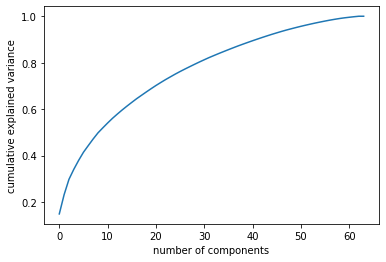

In [47]:
pca.fit(df)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# how can we see how much of the variance is explained by the principal components?


In [48]:
df2_plot = pd.DataFrame(pca.fit_transform(df))

In [49]:
df2_plot.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-19.795782,-0.115269,5.968917,4.753293,4.882164,18.925913,-13.214184,18.043066,-18.626707,-7.348662,...,-5.424981,6.708294,-11.137913,-7.952023,-7.956519,-2.697220,1.080630,-0.296699,-1.434358,1.108731e-14
1,-21.546101,1.457350,9.019584,6.767942,2.247604,17.072731,-13.017614,21.332242,-22.117931,-15.279623,...,5.088357,-6.842140,8.405447,6.254126,7.457328,2.394134,-1.595442,0.130771,1.763693,1.108731e-14
2,-25.056621,-1.526093,6.959653,2.785913,10.819648,16.453893,-5.277778,1.429368,-5.709169,0.374562,...,-0.230542,-0.719572,3.666967,-0.559651,0.297488,0.026367,0.611230,-0.819728,0.275194,1.108731e-14
3,-37.409536,11.389478,5.407097,15.442094,16.011475,33.096506,-4.557381,0.870114,4.986030,-3.653117,...,1.471976,1.214849,-0.217072,-2.526325,-1.178492,-0.422744,1.526933,-0.743917,-0.579324,1.108731e-14
4,-50.218642,1.346174,17.599944,15.099862,13.852847,16.943401,-11.533859,-22.145993,18.940241,7.636668,...,-0.229279,0.372817,-1.582442,0.139597,-0.519454,0.642782,-1.248874,0.716150,-0.742957,1.108731e-14


In [50]:
pd.DataFrame([list(df2_plot.iloc[:,:5].std(axis=0, ddof=0)),
              pca.explained_variance_ratio_[:5],
              np.cumsum(pca.explained_variance_ratio_[:5])],
             index=['Standard Deviation', 'Proportion of Variance', 'Cumulative Proportion'],
             columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

,PC1,PC2,PC3,PC4,PC5
Standard Deviation,24.966409,18.639027,16.599553,13.424692,12.688644
Proportion of Variance,0.148929,0.083007,0.065836,0.043060,0.038468
Cumulative Proportion,0.148929,0.231936,0.297772,0.340832,0.379300


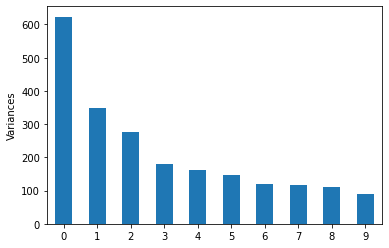

In [51]:
df2_plot.iloc[:,:10].var(axis=0, ddof=0).plot(kind='bar', rot=0) # ddof is delta degree of freedom, rot is rotation for the ticks 
plt.ylabel('Variances');

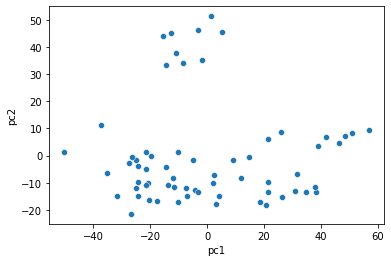

In [52]:
plt.xlabel('pc1')
plt.ylabel('pc2')
sns.scatterplot(x=df2_plot.iloc[:,0],y=df2_plot.iloc[:,1]) # we plot the first two principal components

Now once we have the principal components, the 64 dimensional data can be used to perform silhoutte analysis. 

In [54]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [53]:
def silhoutte_plot(n_clusters): # from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    fig, ax = plt.subplots()

    # The silhouette coefficient can range from -1, 1, but ranges from -0.1 to 1 for our data
    ax.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(df2_plot) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init=50, random_state=rng)
    cluster_labels = clusterer.fit_predict(df2_plot)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df2_plot, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df2_plot, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    plt.title(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

A good number of clusters is such that (1) no cluster is below the average score and (2) the clusters as proportionate as possible in size.

For n_clusters = 2 The average silhouette_score is : 0.11420174418022046
For n_clusters = 3 The average silhouette_score is : 0.10961038782120516
For n_clusters = 4 The average silhouette_score is : 0.11736952028748092
For n_clusters = 5 The average silhouette_score is : 0.10012533686341099
For n_clusters = 6 The average silhouette_score is : 0.1302507214570947


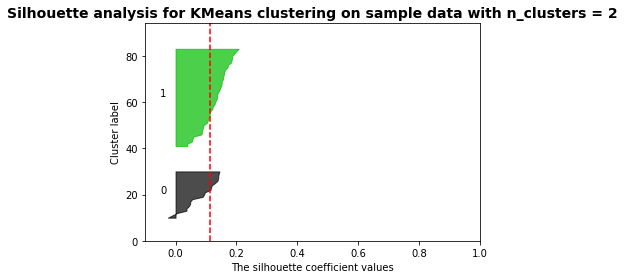

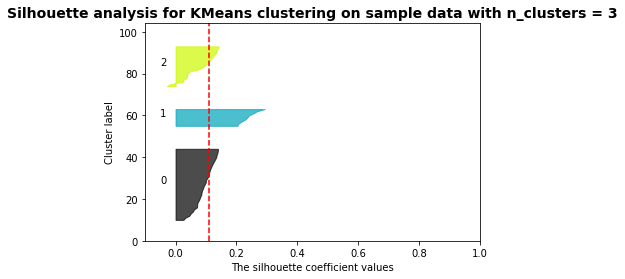

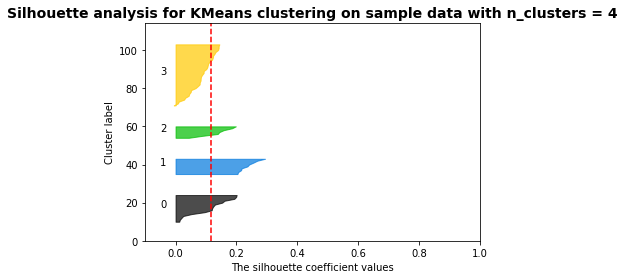

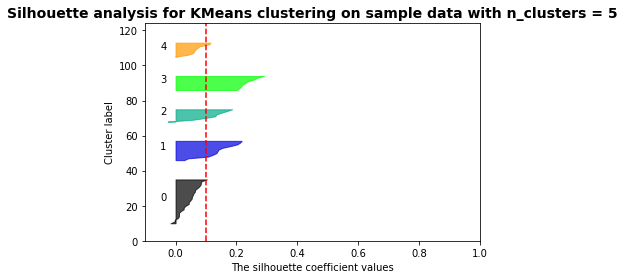

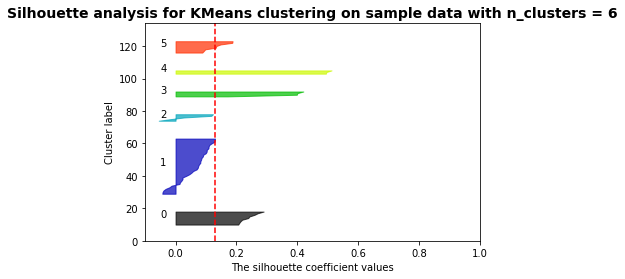

In [55]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    silhoutte_plot(n_clusters)

From the silhoutte analysis, the k=3 and k=4 seem to have good clusters, as for both the cases, the clusters are proportionate in size, and also no cluster is below the average score. Let us visualize the results for k=4 then. 

In [56]:
kmeans_pca = KMeans(n_clusters=4, n_init=100, max_iter=400, init='k-means++', random_state=rng).fit(df2_plot)
print('KMeans PCA Silhouette Score: {}'.format(silhouette_score(df2_plot, kmeans_pca.labels_, metric='euclidean')))
labels_pca = kmeans_pca.labels_
clusters_pca = pd.concat([df2_plot, pd.DataFrame({'pca_clusters':labels_pca})], axis=1)

KMeans PCA Silhouette Score: 0.11636044458884319


In [57]:
clusters_pca.pca_clusters.value_counts()

2    31
0    16
1     9
3     8
Name: pca_clusters, dtype: int64

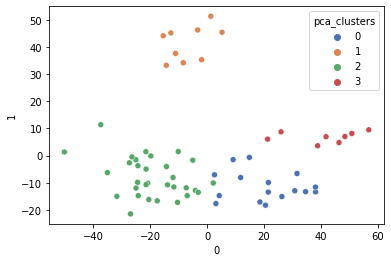

In [58]:
sns.scatterplot(data=clusters_pca, x=clusters_pca.iloc[:,0], y=clusters_pca.iloc[:,1], hue='pca_clusters', palette="deep")

## Elbow Method
This is another method used for selecting the number of clusters. We fit the model with range of K values. If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. 

### Performing dimensionality reduction - tSNE
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. It is extensively applied in image processing, NLP, genomic data and speech processing. In simple terms, t-SNE minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding. This is a particularly useful technique for visualizing high-dimensional data.

In [59]:
from sklearn.manifold import TSNE

In [60]:
# how do we apply tsne and put the results in a dataframe?
tsne = TSNE(n_components = 2, random_state = rng)
df3 = pd.DataFrame(tsne.fit_transform(df), columns = ['tsne1', 'tsne2'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [61]:
df3.shape

(64, 2)

Let us visualize this two dimensional data. 

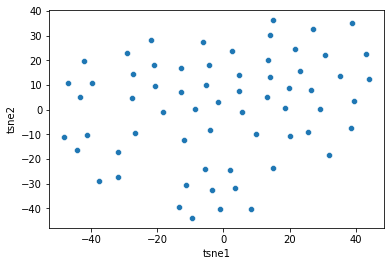

In [62]:
plt.xlabel('tsne1')
plt.ylabel('tsne2')
sns.scatterplot(x=df3.iloc[:,0], y=df3.iloc[:,1])

To find the optimal number of clusters - we plot the sum of squared distances of samples to their closest cluster center, available as ```inertia_``` attribute of the K-Means class. 

In [63]:
sse = []
k_list = range(1, 20)
for k in k_list:
    km = KMeans(n_clusters=k, random_state=rng)
    km.fit(df3)
    sse.append(km.inertia_)
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,20), 'SSE': sse})
tsne_results_scale.head()

,Cluster,SSE
0,1,67924.859375
1,2,36113.910156
2,3,22606.261719
3,4,16784.322266
4,5,13246.402344


Text(0.5, 1.0, 'Optimal Number of Clusters using Elbow Method (tSNE Data)')

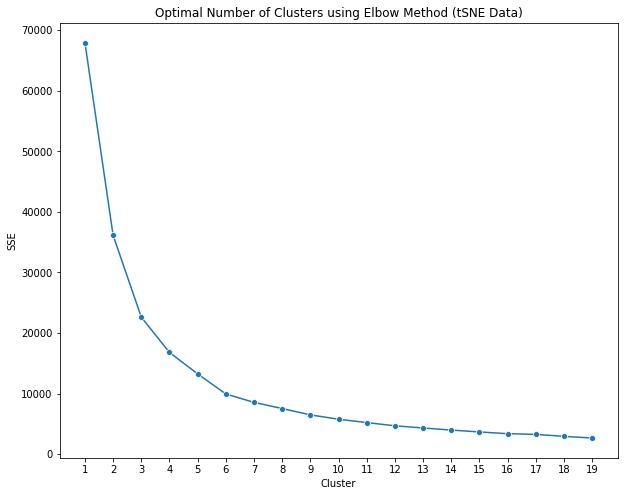

In [64]:
plt.figure(figsize=(10,8))
sns.lineplot(data=tsne_results_scale, x='Cluster', y='SSE', marker='o')
plt.xticks(range(1,20))
plt.title('Optimal Number of Clusters using Elbow Method (tSNE Data)')

We see that the elbow seems to be at k=4. Let us select 4 clusters and visualize. 

In [65]:
kmeans_tsne_scale = KMeans(n_clusters=4, n_init=100, max_iter=400, init='k-means++', random_state=rng).fit(df3)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(df3, kmeans_tsne_scale.labels_, metric='euclidean')))
labels_tsne_scale = kmeans_tsne_scale.labels_
clusters_tsne_scale = pd.concat([df3, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

KMeans tSNE Scaled Silhouette Score: 0.38802021741867065


In [66]:
clusters_tsne_scale.head()

,tsne1,tsne2,tsne_clusters
0,14.222492,30.380573,3
1,14.908033,36.247589,3
2,21.722471,24.520607,3
3,27.042793,32.672726,3
4,43.213364,22.575613,3


In [67]:
clusters_tsne_scale.tsne_clusters.value_counts().sort_index()

0    17
1    12
2    13
3    22
Name: tsne_clusters, dtype: int64

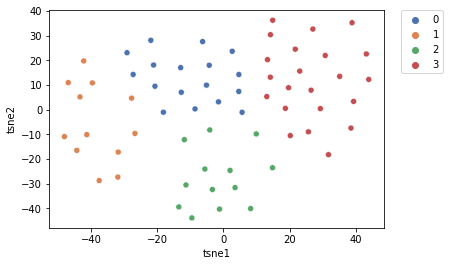

In [68]:
plt.xlabel('tsne1')
plt.ylabel('tsne2')
sns.scatterplot(data=clusters_tsne_scale, x='tsne1', y='tsne2', hue='tsne_clusters', palette='deep')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

A warning: t-SNE often fails to preserve the global geometry of the data. This means that the relative position of clusters on the t-SNE plot is almost arbitrary and depends on random initialisation more than on anything else. While this may not be a problem in some situations, scRNA-seq data sets often exhibit biologically meaningful hierarchical structure, e.g. encompass several very different cell classes, each further divided into various types. Typical t-SNE plots do not capture such global structure, yielding a suboptimal and potentially misleading visualisation. So, t-SNE may not always yield best dimensionality reduction for genetic data, however, it has shown very good results for high-dimensional data in general.

### How would we analyze which clustering is most representative for this type of data?
Usually the domain knowledge of the cancer types and which algorithm has given us good clusters which are most representative is evaluated. Another approach used for gene data is to evaluate the different patient characteristics, such as Age, co-morbidities, etc. to find if the clusters are actually identifying such patterns. Also, using multiple datasets is usually required in such unsupervised tasks. 